## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os

In [3]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


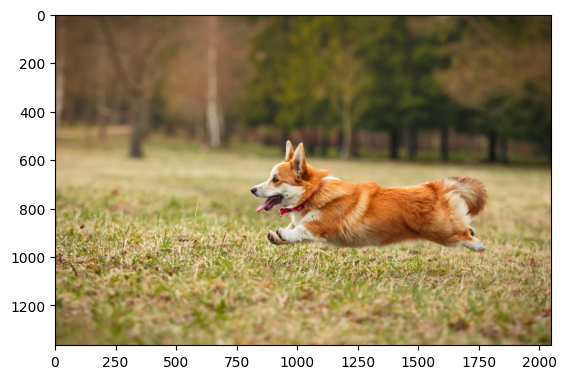

In [6]:
from einops import rearrange
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

### Preprocessing

In [7]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [8]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [9]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [10]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

#### 400x400

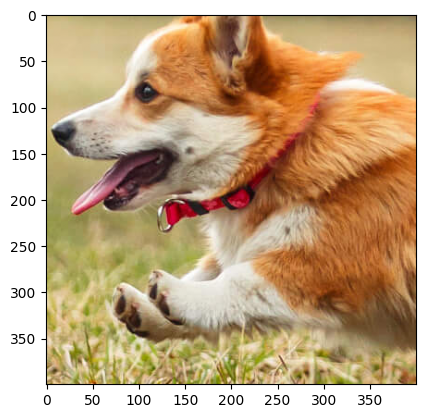

In [11]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

#### Resize to 200x200

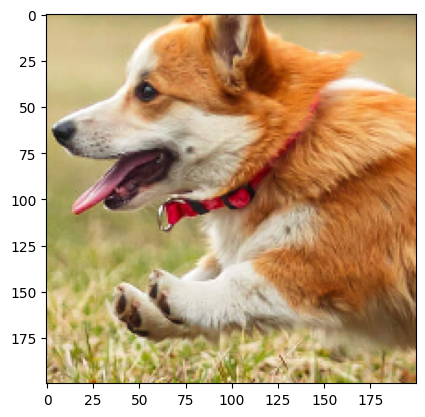

In [12]:
from torch.nn.functional import interpolate
rcrop = interpolate(crop.unsqueeze(0), size=(200, 200), mode='nearest').squeeze(0)
plt.imshow(rearrange(rcrop, 'c h w -> h w c').cpu().numpy())

In [13]:
rcrop.shape

torch.Size([3, 200, 200])

### Coordinate Map

In [14]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    
    """
    
    num_channels, height, width = img.shape
    
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    
    return X, Y

In [15]:
dog_X, dog_Y = create_coordinate_map(rcrop)
dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [16]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()

### Linear Model

In [17]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [18]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)

    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)   
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

In [20]:
train(net, 0.5, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 1.107571
Epoch 100 loss: 0.034432
Epoch 200 loss: 0.034417
Epoch 300 loss: 0.034417
Epoch 400 loss: 0.034417
Epoch 500 loss: 0.034417
Epoch 600 loss: 0.034417
Epoch 700 loss: 0.034417
Epoch 800 loss: 0.034417
Epoch 900 loss: 0.034417


0.03441701829433441

In [21]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

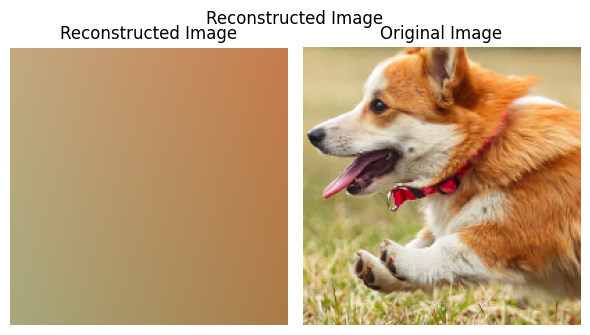

In [22]:
plot_reconstructed_and_original_image(rcrop, net, dog_X_scaled, title="Reconstructed Image")

## RFF Feature Extraction

In [23]:
rff_features = 10000
sigma = 0.05

In [24]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [25]:
X_rff = create_rff_features(dog_X_scaled, 8000, 0.01)

In [26]:
X_rff.shape

torch.Size([40000, 8000])

In [27]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 200)

Epoch 0 loss: 0.368053
Epoch 100 loss: 0.051700


0.01566038466989994

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.066414654..0.9977043].


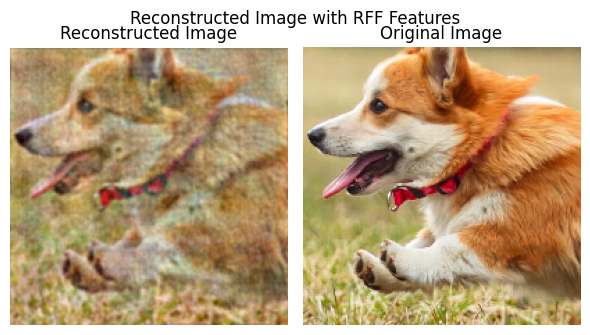

In [28]:
plot_reconstructed_and_original_image(rcrop, net, X_rff, title="Reconstructed Image with RFF Features")

## Super-Resolution

In [29]:
coor_scale = 2
f_no = 10000
sigma = 0.05

In [30]:
num_channels, orig_height, orig_width = rcrop.shape

new_height = orig_height * coor_scale
new_width = orig_width * coor_scale

coords = np.array([[i / coor_scale, j / coor_scale] for i in range(new_height) for j in range(new_width)])
Xten = torch.tensor(coords, dtype=torch.float32).to(device)

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Xten.cpu())
Xten_scaled = scaler_X.transform(Xten.cpu())
Xten_scaled = torch.tensor(Xten_scaled, dtype=torch.float32).to(device)

X_rff = create_rff_features(Xten_scaled, f_no, sigma)

In [31]:
X_rff.shape

torch.Size([160000, 10000])

In [32]:
dog_iX, dog_iY = create_coordinate_map(crop)

In [33]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
loss = train(net, 0.002, X_rff, dog_iY, 200)

net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(new_height, new_width, num_channels)

Epoch 0 loss: 0.365839
Epoch 100 loss: 0.064566


### Q1 Output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18164732..1.0349021].


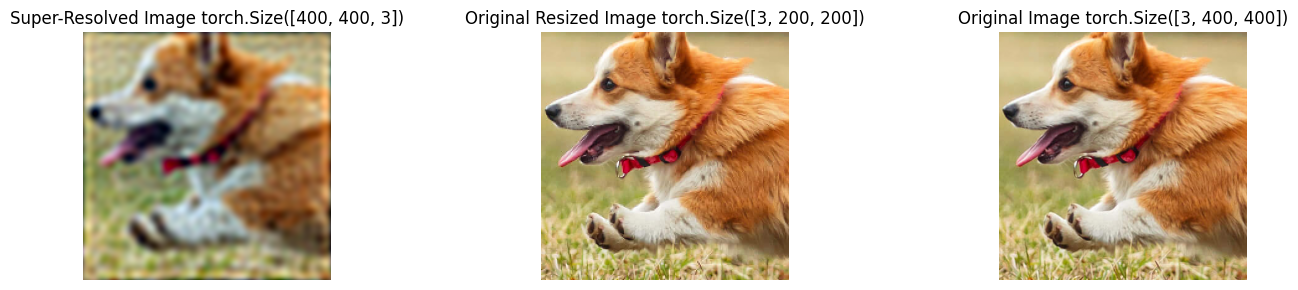

In [34]:
fig = plt.figure(figsize=(15, 3))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax0 = plt.subplot(gs[0])
ax0.imshow(outputs.cpu().numpy())
ax0.set_title(f"Super-Resolved Image {outputs.shape}")

ax1 = plt.subplot(gs[1])
ax1.imshow(rcrop.cpu().permute(1, 2, 0).numpy())
ax1.set_title(f"Original Resized Image {rcrop.shape}")

ax2 = plt.subplot(gs[2])
ax2.imshow(crop.cpu().permute(1, 2, 0).numpy())
ax2.set_title(f"Original Image {crop.shape}")

for a in [ax0, ax1, ax2]:
    a.axis("off")

plt.tight_layout()
plt.show()

## Q2

In [35]:
ground_truth = crop.permute(1,2,0)
final_image = torch.tensor(outputs).permute(2, 0, 1).float() / 255.0
ground_truth = torch.tensor(ground_truth).clone().detach().permute(2, 0, 1).float() / 255.0

rmse_list = []
psnr_list = []

for channel in range(final_image.shape[0]):
    mse = F.mse_loss(final_image[channel], ground_truth[channel])
    rmse = torch.sqrt(mse)
    rmse_list.append(rmse.item())

    max_pixel_value = 1.0
    psnr = 10 * torch.log10((max_pixel_value**2) / mse) if mse.item() > 0 else float('inf')
    psnr_list.append(psnr.item())

overall_rmse = np.mean(rmse_list)
overall_psnr = np.mean(psnr_list)
print(f"Overall RMSE: {overall_rmse}, Overall PSNR: {overall_psnr}")

Overall RMSE: 0.0004281683941371739, Overall PSNR: 67.82122039794922


C:\Users\aashm\AppData\Local\Temp\ipykernel_17572\798280540.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_image = torch.tensor(outputs).permute(2, 0, 1).float() / 255.0
C:\Users\aashm\AppData\Local\Temp\ipykernel_17572\798280540.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(ground_truth).clone().detach().permute(2, 0, 1).float() / 255.0
